# How to download flights csv file from transtats website

**In this notebook, we will**
1. Download a csv file for your chosen year(s) and month(s)
2. Prepare the data for further processing
3. Push the prepared data to a table in the database




In [1]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import psycopg2
import requests #package for getting data from the web
from zipfile import * #package for unzipping zip files
from sql import get_engine #adjust this as necessary to match your sql.py connection methods

# 1. Download csv file with flight data for your specific year/month

In the following, you are going to download a csv file containing flight data from [this website](https://transtats.bts.gov).    
You can specify, which data you want to download. 

Choose a month/year that you want to explore further.
With the following command lines, you will download a csv file on public flight data from [this website](https://transtats.bts.gov) containing data of your chosen month/year.    
The file will be stored in a data folder.

In [2]:
# Specifies path for saving file
path ='data/' 
# Create the data folder
!mkdir {path}

mkdir: data/: File exists


In [3]:
years = [2011, 2012] # list of years you want to look at, specify one year
months = [10, 11, 12] # list of months you want to look at, specify one month
# Here: October, November, October 2011 and 2012 / 1 file ca. 23 mb

# Loop through months
for year in years:
    for month in months:
        # Get the file from the website https://transtats.bts.gov
        zip_file = f'On_Time_Reporting_Carrier_On_Time_Performance_1987_present_{year}_{month}.zip'
        csv_file = f'On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_{year}_{month}.csv'
        url = (f'https://transtats.bts.gov/PREZIP/{zip_file}')
        # Download the database
        r = requests.get(f'{url}', verify=False)
        # Save database to local file storage
        with open(path+zip_file, 'wb') as f:
            f.write(r.content)

/usr/local/Caskroom/miniconda/base/envs/capstone/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'transtats.bts.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/capstone/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'transtats.bts.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/capstone/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'transtats.bts.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/

In [11]:
# Unzip your files 220 Mb / per file
for month in months:
    zip_files = f'On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2011_{month}.zip'
    with ZipFile(path+zip_files, 'r') as zip_ref:
        zip_ref.extractall(path)

In [54]:
# Read in your data # How to append multiple 
months = [10]
months_df = pd.DataFrame()
for month in range(10,11)):
    month_df = pd.read_csv(f'data/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2012_{month}.csv', low_memory = False)
    months_df.append(month_df)

In [60]:
flights_df_2011_10 = pd.read_csv(f'data/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2011_10.csv', low_memory = False)
flights_df_2011_11 = pd.read_csv(f'data/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2011_11.csv', low_memory = False)
flights_df_2011_12 = pd.read_csv(f'data/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2011_12.csv', low_memory = False)
flights_df_2012_10 = pd.read_csv(f'data/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2012_10.csv', low_memory = False)
flights_df_2012_11 = pd.read_csv(f'data/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2012_11.csv', low_memory = False)
flights_df_2012_12 = pd.read_csv(f'data/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2012_12.csv', low_memory = False)

In [61]:
type(flights_df_2011_10)

pandas.core.frame.DataFrame

In [63]:
flights_df_2011_12.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493888 entries, 0 to 493887
Columns: 110 entries, Year to Unnamed: 109
dtypes: float64(70), int64(21), object(19)
memory usage: 414.5+ MB


In [69]:
# Combine your date
flights_df1 = flights_df_2011_10.append(flights_df_2011_11)
flights_df2 = flights_df1.append(flights_df_2011_12)
flights_df3 = flights_df2.append(flights_df_2012_10)
flights_df4 = flights_df3.append(flights_df_2012_11)
df = flights_df4.append(flights_df_2012_12)
display(flights_df.shape)
display(flights_df.head())

(2973803, 110)

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,...,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Unnamed: 109
0,2011,4,10,1,6,2011-10-01,AA,19805,AA,N320AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011,4,10,2,7,2011-10-02,AA,19805,AA,N327AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011,4,10,3,1,2011-10-03,AA,19805,AA,N339AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011,4,10,4,2,2011-10-04,AA,19805,AA,N323AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011,4,10,5,3,2011-10-05,AA,19805,AA,N328AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Read in your data
# df = pd.read_csv(path+csv_file, low_memory = False)
# display(df.shape)
# display(df.head())

(515254, 110)

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,...,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Unnamed: 109
0,2012,4,10,1,1,2012-10-01,AA,19805,AA,N320AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2012,4,10,2,2,2012-10-02,AA,19805,AA,N319AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2012,4,10,3,3,2012-10-03,AA,19805,AA,N319AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2012,4,10,4,4,2012-10-04,AA,19805,AA,N325AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012,4,10,5,5,2012-10-05,AA,19805,AA,N325AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2973803 entries, 0 to 494217
Columns: 110 entries, Year to Unnamed: 109
dtypes: float64(69), int64(21), object(20)
memory usage: 2.5+ GB


# 2. Prepare the csv file for further processing

In the next step, we clean and prepare our dataset.

a) Since the dataset consists of a lot of columns, we we define which ones to keep.

In [71]:
# Columns from downloaded file that are to be kept

columns_to_keep = [
                'FlightDate',
                'DepTime',
                'CRSDepTime',
                'DepDelay',
                'ArrTime',
                'CRSArrTime',
                'ArrDelay',
                'Reporting_Airline',
                'Tail_Number',
                'Flight_Number_Reporting_Airline',
                'Origin',
                'Dest',
                'AirTime',
                'Distance',
                'Cancelled',
                'Diverted'
]

In [72]:
df[columns_to_keep].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2973803 entries, 0 to 494217
Data columns (total 16 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   FlightDate                       object 
 1   DepTime                          float64
 2   CRSDepTime                       int64  
 3   DepDelay                         float64
 4   ArrTime                          float64
 5   CRSArrTime                       int64  
 6   ArrDelay                         float64
 7   Reporting_Airline                object 
 8   Tail_Number                      object 
 9   Flight_Number_Reporting_Airline  int64  
 10  Origin                           object 
 11  Dest                             object 
 12  AirTime                          float64
 13  Distance                         float64
 14  Cancelled                        float64
 15  Diverted                         float64
dtypes: float64(8), int64(3), object(5)
memory usage: 385.7+

In [73]:
# set up your database connection
engine = get_engine()

In [74]:
# The columns in the DB have different naming as in the source csv files. Lets get the names from the DB
table_name_sql = '''SELECT COLUMN_NAME 
                    FROM INFORMATION_SCHEMA.COLUMNS 
                    WHERE TABLE_NAME = 'flights'
                    AND TABLE_SCHEMA ='public'
                    ORDER BY ordinal_position'''
c_names = engine.execute(table_name_sql).fetchall()
c_names

[('flight_date',),
 ('dep_time',),
 ('sched_dep_time',),
 ('dep_delay',),
 ('arr_time',),
 ('sched_arr_time',),
 ('arr_delay',),
 ('airline',),
 ('tail_number',),
 ('flight_number',),
 ('origin',),
 ('dest',),
 ('air_time',),
 ('distance',),
 ('cancelled',),
 ('diverted',)]

In [75]:
# we can clean up the results into a clean list
new_column_names=[]
for name in c_names:
    new_column_names.append(name[0])
new_column_names        

['flight_date',
 'dep_time',
 'sched_dep_time',
 'dep_delay',
 'arr_time',
 'sched_arr_time',
 'arr_delay',
 'airline',
 'tail_number',
 'flight_number',
 'origin',
 'dest',
 'air_time',
 'distance',
 'cancelled',
 'diverted']

In [76]:
# Just in case the above fails here are the results
new_column_names_alternate = ['flight_date',
                              'dep_time',
                              'sched_dep_time',
                              'dep_delay',
                              'arr_time',
                              'sched_arr_time',
                              'arr_delay',
                              'airline',
                              'tail_number',
                              'flight_number',
                              'origin',
                              'dest',
                              'air_time',
                              'distance',
                              'cancelled',
                              'diverted' ]

b) With the next function, we make our csv file ready to be uploaded to SQL.  
We only keep to above specified columns and convert the datatypes.

In [77]:
def clean_airline_df(df):
    '''
    Transforms a df made from BTS csv file into a df that is ready to be uploaded to SQL
    Set rows=0 for no filtering
    '''

    # Build dataframe including only the columns you want to keep
    df_airline = df.loc[:,columns_to_keep]
     
    # Clean data types and NULLs
    df_airline['FlightDate']= pd.to_datetime(df_airline['FlightDate'], yearfirst=True)
    df_airline['CRSArrTime']= pd.to_numeric(df_airline['CRSArrTime'], downcast='integer', errors='coerce')
    df_airline['Cancelled']= pd.to_numeric(df_airline['Cancelled'], downcast='integer')
    df_airline['Diverted']= pd.to_numeric(df_airline['Diverted'], downcast='integer')
    
    # Rename columns
    df_airline.columns = new_column_names
    
    return df_airline

In [78]:
# Call function and check resulting dataframe
df_clean = clean_airline_df(df)
df_clean.head()

,flight_date,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,airline,tail_number,flight_number,origin,dest,air_time,distance,cancelled,diverted
0,2011-10-01,850.0,900,-10.0,1103.0,1207,-64.0,AA,N320AA,1,JFK,LAX,295.0,2475.0,0,0
1,2011-10-02,855.0,900,-5.0,1120.0,1207,-47.0,AA,N327AA,1,JFK,LAX,294.0,2475.0,0,0
2,2011-10-03,854.0,900,-6.0,1113.0,1207,-54.0,AA,N339AA,1,JFK,LAX,294.0,2475.0,0,0
3,2011-10-04,857.0,900,-3.0,1151.0,1207,-16.0,AA,N323AA,1,JFK,LAX,309.0,2475.0,0,0
4,2011-10-05,851.0,900,-9.0,1146.0,1207,-21.0,AA,N328AA,1,JFK,LAX,333.0,2475.0,0,0


If you decide to only look at specific airports, it is a good decision to filter for them in advance.  
This function does the filtering. 

In [79]:
# Specify the airports you are interested in and put them as a list in the function.
def select_airport(df, airports):
    ''' Helper function for filtering airline df for a subset of airports'''
    df_out = df.loc[(df.origin.isin(airports)) | (df.dest.isin(airports))]
    return df_out

In [80]:
# Execute function, filtering for New York area airports
airports=['BOS', 'EWR', 'JFK', 'MIA', 'PHI', 'SJU']
if len(airports) > 0:
    df_selected_airports = select_airport(df_clean, airports)
else:
    df_selected_airports = df_clean
    
df_selected_airports.head()

,flight_date,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,airline,tail_number,flight_number,origin,dest,air_time,distance,cancelled,diverted
0,2011-10-01,850.0,900,-10.0,1103.0,1207,-64.0,AA,N320AA,1,JFK,LAX,295.0,2475.0,0,0
1,2011-10-02,855.0,900,-5.0,1120.0,1207,-47.0,AA,N327AA,1,JFK,LAX,294.0,2475.0,0,0
2,2011-10-03,854.0,900,-6.0,1113.0,1207,-54.0,AA,N339AA,1,JFK,LAX,294.0,2475.0,0,0
3,2011-10-04,857.0,900,-3.0,1151.0,1207,-16.0,AA,N323AA,1,JFK,LAX,309.0,2475.0,0,0
4,2011-10-05,851.0,900,-9.0,1146.0,1207,-21.0,AA,N328AA,1,JFK,LAX,333.0,2475.0,0,0


# 3. Push the prepared data to a table in the database

In [81]:
df_selected_airports.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389158 entries, 0 to 493754
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   flight_date     389158 non-null  datetime64[ns]
 1   dep_time        379506 non-null  float64       
 2   sched_dep_time  389158 non-null  int64         
 3   dep_delay       379506 non-null  float64       
 4   arr_time        379210 non-null  float64       
 5   sched_arr_time  389158 non-null  int16         
 6   arr_delay       378602 non-null  float64       
 7   airline         389158 non-null  object        
 8   tail_number     386021 non-null  object        
 9   flight_number   389158 non-null  int64         
 10  origin          389158 non-null  object        
 11  dest            389158 non-null  object        
 12  air_time        378602 non-null  float64       
 13  distance        389158 non-null  float64       
 14  cancelled       389158 non-null  int

In [82]:
# Specify which table within your database you want to push your data to. Give your table an unambiguous name.
# Example: flights_sp for Sina's flights table
table_name = 'group4_flights_data'
# If the specified table doesn't exist yet, it will be created
# With 'replace', your data will be replaced if the table already exists.
# This will take a minute or two...

# Write records stored in a dataframe to SQL database
if engine!=None:
    try:
        df_selected_airports.to_sql(name=table_name, # Name of SQL table
                        con=engine, # Engine or connection
                        if_exists='replace', # Drop the table before inserting new values 
                        index=False, # Write DataFrame index as a column
                        chunksize=5000, # Specify the number of rows in each batch to be written at a time
                        method='multi') # Pass multiple values in a single INSERT clause
        print(f"The {table_name} table was imported successfully.")
    # Error handling
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        engine = None

The group4_flights_data table was imported successfully.


In [83]:
# Check the number of rows match
table_name_sql = f'''SELECT count(*) 
                    FROM {table_name}
                    '''
engine.execute(table_name_sql).fetchall()[0][0] == df_selected_airports.shape[0]

True

# 4. EDA on the flights data

In [87]:
flights_data = df_selected_airports

In [88]:
flights_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389158 entries, 0 to 493754
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   flight_date     389158 non-null  datetime64[ns]
 1   dep_time        379506 non-null  float64       
 2   sched_dep_time  389158 non-null  int64         
 3   dep_delay       379506 non-null  float64       
 4   arr_time        379210 non-null  float64       
 5   sched_arr_time  389158 non-null  int16         
 6   arr_delay       378602 non-null  float64       
 7   airline         389158 non-null  object        
 8   tail_number     386021 non-null  object        
 9   flight_number   389158 non-null  int64         
 10  origin          389158 non-null  object        
 11  dest            389158 non-null  object        
 12  air_time        378602 non-null  float64       
 13  distance        389158 non-null  float64       
 14  cancelled       389158 non-null  int

In [140]:
flights_data.describe()

,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,flight_number,air_time,distance,cancelled,diverted
count,379506.000000,389158.000000,379506.000000,379210.000000,389158.000000,378602.000000,389158.000000,378602.000000,389158.000000,389158.000000,389158.000000
mean,1332.175544,1328.269436,8.938091,1493.109449,1514.860668,3.208015,1667.258381,148.772402,1094.178205,0.025252,0.001873
std,493.543242,479.469366,33.996211,536.170990,514.796963,37.142507,1441.090190,88.020488,741.106732,0.156890,0.043241
min,1.000000,9.000000,-37.000000,1.000000,1.000000,-92.000000,1.000000,14.000000,68.000000,0.000000,0.000000
25%,911.000000,910.000000,-5.000000,1107.000000,1122.000000,-15.000000,599.000000,82.000000,529.000000,0.000000,0.000000
50%,1329.000000,1325.000000,-2.000000,1528.000000,1538.000000,-5.000000,1225.000000,132.000000,946.000000,0.000000,0.000000
75%,1734.000000,1725.000000,7.000000,1934.000000,1935.000000,9.000000,2098.000000,190.000000,1475.000000,0.000000,0.000000
max,2400.000000,2359.000000,1445.000000,2400.000000,2359.000000,1446.000000,6160.000000,673.000000,4983.000000,1.000000,1.000000


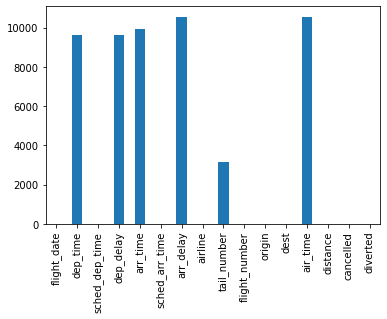

In [141]:
# Are there any null values or outliers? How will you wrangle/handle them?
flights_data.isna().sum()
flights_data.isna().sum().plot.bar();

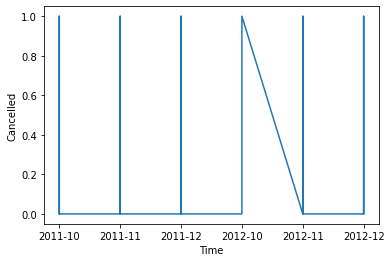

In [150]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(flights_data['flight_date'], flights_data['cancelled'])
ax.set_xlabel('Time')
ax.set_ylabel('Cancelled')
plt.show()

In [142]:
flights_data.groupby('flight_date')[['cancelled', 'diverted']].sum()

,cancelled,diverted
flight_date,,
2011-10,920.0,158.0
2011-11,333.0,113.0
2011-12,450.0,91.0
2012-10,5450.0,99.0
2012-11,1699.0,122.0
2012-12,975.0,146.0


In [145]:
flights_data[['dep_delay', 'arr_delay']].head()

,dep_delay,arr_delay
0,-10.0,-64.0
1,-5.0,-47.0
2,-6.0,-54.0
3,-3.0,-16.0
4,-9.0,-21.0


In [143]:
flights_data.groupby('flight_date')[['dep_delay', 'arr_delay']].mean()

,dep_delay,arr_delay
flight_date,,
2011-10,8.216126,3.929782
2011-11,6.021246,-0.274453
2011-12,8.309443,1.437750
2012-10,9.665390,5.113147
2012-11,7.589444,0.269191
2012-12,13.570076,8.529034
